## Libraries

In [222]:
!pip install -q mrjob

## Task Solution

In [223]:
ls ../data

MR1/  MR3/                           SW_EpisodeIV.txt  SW_EpisodeVI.txt
MR2/  PrinciplesOfLazersZvelto.pdf*  SW_EpisodeV.txt   rubrics.json


In [224]:
path_to_txt = "../data/SW_EpisodeIV.txt"

In [313]:
with open(path_to_txt, "r") as fo:
    exp = fo.readlines()

In [314]:
line = exp[13]

In [315]:
print(line.split('" "'))

['"13', 'REBEL OFFICER', 'We intercepted no transmissions. Aaah...  This is a consular ship. Were on a diplomatic mission."\n']


In [363]:
exp[0].split('" "')[1]

'dialogue"\n'

### MapRed Job

In [316]:
%%file most_talking.py

from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import defaultdict
from operator import itemgetter

class MR20MostTalking(MRJob):

    def init_get_counts(self):
        self.counts = defaultdict(int)
    
    def get_counts(self, _, line):
        chr_name = line.split('" "')[1]
        if chr_name == "dialogue":
            # Skip excess line
            pass
        else:
            self.counts[chr_name] += 1

    def final_get_counts(self):
        for word, val in self.counts.items():
            yield word, val

    def sum_counts(self, characters, counts):
        # Key to None to have output as the list of tuples
        yield None, (characters, sum(counts))

    def select_top_20(self, _, pairs):
        sorted_pairs = sorted(pairs, reverse=True, key=itemgetter(1))
        for pair in sorted_pairs[:20]:
            yield pair

    def steps(self):
        return [MRStep(mapper_init=self.init_get_counts,
                       mapper=self.get_counts,
                       mapper_final=self.final_get_counts,
                       reducer=self.sum_counts,
                      ),
               MRStep(reducer=self.select_top_20)
               ]

if __name__ == '__main__':
    MR20MostTalking.run()

Overwriting most_talking.py


## Test locally

In [317]:
!python3 most_talking.py "../data/SW_EpisodeIV.txt"

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/most_talking.root.20231129.194932.894892
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/most_talking.root.20231129.194932.894892/output
Streaming final output from /tmp/most_talking.root.20231129.194932.894892/output...
"LUKE"	254
"HAN"	153
"THREEPIO"	119
"BEN"	82
"LEIA"	57
"VADER"	41
"RED LEADER"	37
"BIGGS"	34
"TARKIN"	28
"OWEN"	25
"TROOPER"	19
"GOLD LEADER"	14
"WEDGE"	14
"OFFICER"	11
"RED TEN"	8
"GOLD FIVE"	7
"GREEDO"	6
"INTERCOM VOICE"	6
"AUNT BERU"	6
"DEATH STAR INTERCOM VOICE"	6
Removing temp directory /tmp/most_talking.root.20231129.194932.894892...


## Running on the cluster

### Put the data on the cluster

In [324]:
!hadoop fs -ls /

Found 5 items
drwxr-xr-x   - root supergroup          0 2023-11-29 22:51 /MR_data
drwxr-xr-x   - root supergroup          0 2023-11-29 22:11 /MR_data2
drwxr-xr-x   - root supergroup          0 2023-11-28 21:33 /book
drwx-wx-wx   - root supergroup          0 2023-11-28 21:21 /tmp
drwxr-xr-x   - root supergroup          0 2023-11-28 21:21 /user


In [325]:
!hadoop fs -mkdir /MR_data1

In [326]:
!hadoop fs -put -f ../data/SW_EpisodeIV.txt /MR_data && \
 hadoop fs -put -f ../data/SW_EpisodeV.txt /MR_data && \
 hadoop fs -put -f ../data/SW_EpisodeVI.txt /MR_data

### Let's go

Test with one file

In [329]:
!python3 most_talking.py -r hadoop hdfs:///MR_data/SW_EpisodeIV.txt --output /MR_data1/outputIV

No configs found; falling back on auto-configuration
No configs specified for hadoop runner
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_talking.root.20231129.195234.672170
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_talking.root.20231129.195234.672170/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_talking.root.20231129.195234.672170/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar4629096882885619471/] [] /tmp/streamjob7150588165224265759.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.3:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701267673176_

In [330]:
!hadoop fs -cat /MR_data1/outputIV/part-00000

"LUKE"	254
"HAN"	153
"THREEPIO"	119
"BEN"	82
"LEIA"	57
"VADER"	41
"RED LEADER"	37
"BIGGS"	34
"TARKIN"	28
"OWEN"	25
"TROOPER"	19
"WEDGE"	14
"GOLD LEADER"	14
"OFFICER"	11
"RED TEN"	8
"GOLD FIVE"	7
"JABBA"	6
"INTERCOM VOICE"	6
"GREEDO"	6
"FIRST TROOPER"	6


Run the rest

In [331]:
!python3 most_talking.py -r hadoop hdfs:///MR_data/SW_EpisodeV.txt --output /MR_data1/outputV && \
 python3 most_talking.py -r hadoop hdfs:///MR_data/SW_EpisodeVI.txt --output /MR_data1/outputVI && \
 python3 most_talking.py -r hadoop hdfs:///MR_data/SW_EpisodeIV.txt \
                                   hdfs:///MR_data/SW_EpisodeV.txt \
                                   hdfs:///MR_data/SW_EpisodeVI.txt  --output /MR_data1/outputALL

No configs found; falling back on auto-configuration
No configs specified for hadoop runner
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_talking.root.20231129.195513.110506
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_talking.root.20231129.195513.110506/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_talking.root.20231129.195513.110506/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar5543341551914287936/] [] /tmp/streamjob7047598388204354303.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.3:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701267673176_

## Collect Data Result

In [332]:
!pip install -q pandas matplotlib

In [333]:
!hadoop fs -get -f /MR_data1/outputIV/part-00000  ../data/MR1/outputIV.txt && \
 hadoop fs -get -f /MR_data1/outputV/part-00000  ../data/MR1/outputV.txt && \
 hadoop fs -get -f /MR_data1/outputVI/part-00000  ../data/MR1/outputVI.txt && \
 hadoop fs -get -f /MR_data1/outputALL/part-00000  ../data/MR1/outputALL.txt

In [334]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [335]:
path_to_data = "../data/MR1"

files = os.listdir(path_to_data)

In [336]:
files

['outputALL.txt', 'outputVI.txt', 'outputV.txt', 'outputIV.txt']

In [353]:
def mysplit(s):
    head = s.rstrip('0123456789')
    tail = s[len(head):]
    return head[:-1], tail

In [354]:
dfs = []
dfs_names = []
for file in files:
    with open(os.path.join(path_to_data, file), "r") as fo:
        data = fo.read().replace("\t", " ").split("\n")
    data = [mysplit(item.replace('"', '')) for item in data[:-1]]
    
    df = pd.DataFrame(data, columns=["Character", "Counts"])
    df.Counts = df.Counts.astype(int)
    
    dfs.append(df)
    dfs_names.append(file.split(".")[0])

In [355]:
# Example
pd.concat([dfs[0].head(), dfs[0].tail()])

,Character,Counts
0,LUKE,494
1,HAN,459
2,THREEPIO,301
3,LEIA,227
4,VADER,140
15,OWEN,25
16,CREATURE,22
17,TROOPER,19
18,GOLD LEADER,14
19,ACKBAR,14


## EDA

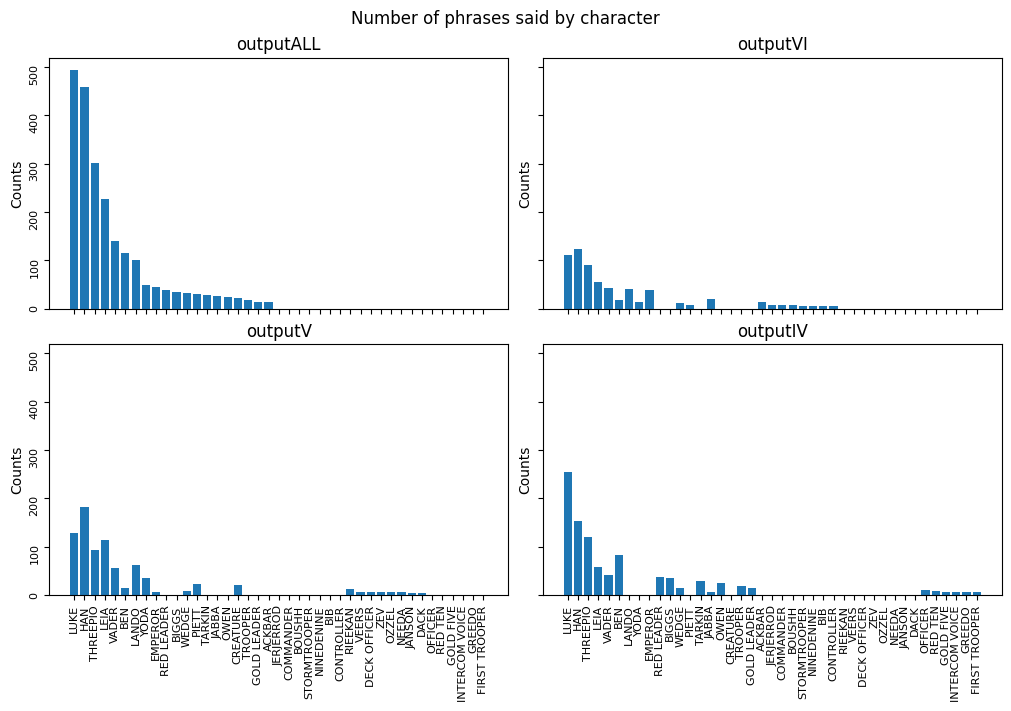

In [356]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, layout="constrained", figsize=(10, 7))

for i in range(len(dfs)):
    axs[i // 2, i % 2].bar(x=dfs[i].Character, height=dfs[i].Counts)
    axs[i // 2, i % 2].set_title(f"{dfs_names[i]}")
    axs[i // 2, i % 2].set_ylabel("Counts")
    axs[i // 2, i % 2].tick_params(labelrotation=90, labelsize=8)
    
fig.suptitle("Number of phrases said by character");

### Little test

In [357]:
from functools import reduce

In [358]:
# Merge by index result of 3 outputs
merged = reduce(
    lambda x, y: pd.merge(x, y, how='outer', left_index=True, right_index=True), 
    [df.set_index('Character').sort_index() for df in dfs[1:]]
).fillna(0)

In [359]:
# Get the 20 most talking for all chapters
merged['Total'] = merged["Counts"] + merged["Counts_x"] + merged["Counts_y"]
all_test = merged.sort_values('Total', ascending=False).Total.values[:20]

In [360]:
np.equal(dfs[0].Counts.values, all_test)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True])

Есть пару отличий для прогона для всех скриптов сразу.Хммм....